In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as dt
import matplotlib.ticker as ticker
import datetime
import pickle
import copy 
sys.path.insert(0, os.path.abspath('../'))
import c19all

df_start = pickle.load(open( '../../output/pickles/df_us_combined.p', 'rb')).reset_index()

SOURCE_LABELS = {'nyt': 'New York Times', 'jhu': 'Johns Hopkins University'}

In [2]:
# If you pass in a population, the output will be per 1,000 people
# If you pass in an output filename, the plots will be written to ./images and not rendered to the screen
def county_plot(county, state, metric='cases', source='nyt', population=None, output_filename=None):
    df = copy.deepcopy(df_start)
    start_date = pd.to_datetime('2020-03-01')
    location = {
        'type': 'county',
        'value': [county, state]
    }
    count_of = f'{metric}_{source}'

    if 'location' in locals():
        if location['type'] == 'county':
            county = location['value'][0]
            state = location['value'][1]
            df = df[df.county == county]
            df = df[df.state == state]
            ylabel = f'{county} county, {state} {count_of}'       
        else:
            df = df[df[location['type']] == location['value']]
            ylabel = f'{location["value"]} {location["type"]} {count_of}'
    else:
        ylabel = f'US { count_of}'

    df = df[df.date >= start_date]
    if population:
        df[count_of] = df[count_of].apply(lambda x: (x / population) * 100000)
    df['count_of_diff'] = df[count_of].diff()
    df['count_of_diff_7_day_mean'] = df.count_of_diff.rolling(7).mean()
    df = df.iloc[1:];

    fig = plt.figure(figsize=(7,3))

    ax = fig.add_subplot(111)
    ax.bar('date', 'count_of_diff', data=df, alpha=0.35)
    ax.plot('date', 'count_of_diff_7_day_mean', data=df)
    ax.set_ylim(ymin=0)
    ax.xaxis.set_major_locator(dt.MonthLocator())
    ax.xaxis.set_major_formatter(dt.DateFormatter('%b'))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.grid(axis='x')

    plt.style.use('seaborn-whitegrid')
    plt.text(df.date.iloc[-1] + datetime.timedelta(days=3), df.count_of_diff_7_day_mean.iloc[-1], "7-day\navg.", color='#1f77b4', style='italic', weight='bold')

    # Optional title
    # title_1 = f'New Covid-19 {metric} per day {"per 100,000 residents" if population else ""}'
    # title_2 = f'{county}, {state}'
    # title_3 = f'Source: {SOURCE_LABELS[source]}'
    # plt.title(f'{title_1}\n{title_2}\n{title_3}')
    
    return (plt, ax)

# Pass in a list of plots to get the highest ymax among them all
def ymax(axes):
    ymax = -1.0E20
    for ax in axes:
        this_ymax = ax.get_ylim()[1]
        ymax = this_ymax if this_ymax > ymax else ymax
    return ymax

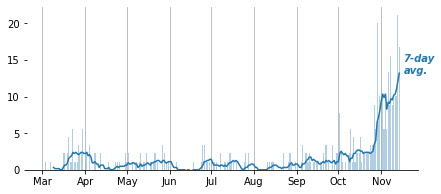

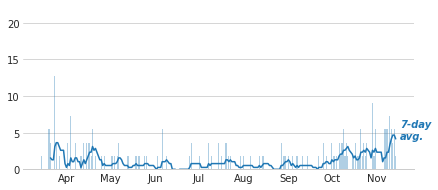

In [3]:
plts = []
axes = []

plt, ax = county_plot(county='Grafton', state='New Hampshire', population=89886)
plts.append(plt)
axes.append(ax)

plt, ax = county_plot(county='Windsor', state='Vermont', population=55062)
plts.append(plt)
axes.append(ax)

ymax_norm = ymax(axes)
for ax in axes:
    ax.set_ylim(ymax=ymax_norm)

for plot in plts:
    plot.show()

